In [1]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from tensorflow import keras
import sys
from pathlib import Path
SELFIES_coder_path = Path("../SELFIES_coder")
sys.path.append(SELFIES_coder_path.as_posix())
import SELFIES_coder as SELFIES_CODER
import selfies as sf

In [2]:
SELFIES_CODER.TEST()

working


In [3]:
mol_seq_to_latent_model = keras.models.load_model('../Neural_network/mol_seq2lat.h5')

In [4]:
mol_seq_to_latent_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 87, 34)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 83456       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          32896       concatenate[0][0]          

In [5]:
latent_to_states_model = keras.models.load_model("../Neural_network/lat2state.h5")

In [6]:
latent_to_states_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       input_3[0][0]                    
Total params: 33,024
Trainable params: 33,024
Non-trainable params: 0
__________________________________________________________________________________________________


In [7]:
sample_model = keras.models.load_model("../Neural_network/samplemodel.h5")

In [8]:
sample_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(1, 1, 34)]              0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 128)               83456     
_________________________________________________________________
dense_4 (Dense)              (1, 1, 34)                4386      
Total params: 87,842
Trainable params: 87,842
Non-trainable params: 0
_________________________________________________________________


#### SMILES SHOULD BE VECTORIZED

In [9]:
# Initial structures to make predictions

smifile = "../Data/initial_caffeine.xlsx"
data = pd.read_excel(smifile)
data = data['SMILES']
initial_structures_new = list(set(data))

In [10]:
frame = pd.DataFrame(initial_structures_new, columns=['SMILES'])
frame.head()

,SMILES
0,CN(C(N1C)=O)C2=C(N(C)C(SC)=N2)C1=O
1,CN1C(N(C)CCN(C=C(/C=C(C(OC)=O)\S)[N+]([O-])=O)...
2,CN(C(C(N(C)C(NCCNCCN)=N1)=C1N2C)=O)C2=O
3,CN1C(N(C)CCCN(C=C(/C=C(C(OC)=O)\S)[N+]([O-])=O...
4,CN1C(SC2=NC3=C(N2)C=CC=C3)=NC2=C1C(=O)N(C)C(=O...


# Only data shorter than embed value can be used

In [11]:
smiles_train = frame['SMILES']
smiles_train

0                    CN(C(N1C)=O)C2=C(N(C)C(SC)=N2)C1=O
1     CN1C(N(C)CCN(C=C(/C=C(C(OC)=O)\S)[N+]([O-])=O)...
2               CN(C(C(N(C)C(NCCNCCN)=N1)=C1N2C)=O)C2=O
3     CN1C(N(C)CCCN(C=C(/C=C(C(OC)=O)\S)[N+]([O-])=O...
4     CN1C(SC2=NC3=C(N2)C=CC=C3)=NC2=C1C(=O)N(C)C(=O...
5       O=C1C2=C(N=C(NCCCN3C(CCC3=O)=O)N2C)N(C)C(N1C)=O
6     CN1C(NCCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N...
7     CN1C(NCCC/N=C2SCC(N/2)=O)=NC3=C1C(N(C)C(N3C)=O)=O
8             CN(C)CCN(C1=NC2=C(N1C)N(C)C(N(C)C2=O)=O)C
9         CN(C(C(N(C)C(NCCCNCCCNCCCN)=N1)=C1N2C)=O)C2=O
10        CN(C(N1C)=O)C2=C(N(C)C(SC(N3CCCC3)=S)=N2)C1=O
11               CNCCN(C)C1=NC2=C(N(C(N(C2=O)C)=O)C)N1C
12    O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC...
13     O=C1C2=C(N=C(NCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
14         CN(C(N1C)=O)C2=C(N(C)C(NCCCCNC(C)=O)=N2)C1=O
15              CNCCCN(C)C1=NC2=C(N(C(N(C2=O)C)=O)C)N1C
16             CN(C(N1C)=O)C2=C(N(C)C(NCCCCCCN)=N2)C1=O
17                  CN(C(N1C)=O)C2=C(N(C)C(SCC)=

In [12]:
#should be equal to [(None, x -THIS, y)] from first loaded model
embed = 88 #x+1

In [13]:
import json
f = open('../Neural_network/mol_seq_to_int.json')
char_to_int = json.load(f)

In [14]:
charset = char_to_int.keys()

In [15]:
to_be_used = len(charset)

In [16]:
import json
f = open('../Neural_network/int_to_mol_seq.json')
int_to_char = json.load(f)

In [17]:
int_to_char = {int(key):int_to_char[key] for key in int_to_char} #removed '' -string form of data

In [18]:
import json
f = open('../Neural_network/mol_seq_to_SELFIES.json')
One_hot_to_SELFIES = json.load(f)

In [19]:
import json
f = open('../Neural_network/SELFIES_to_mol_seq.json')
SELFIES_to_one_hot = json.load(f)

In [20]:
SELFIES_to_one_hot

{'[N+1]': '#',
 '[=Branch2]': '$',
 '[=O]': '%',
 '[Branch1]': '&',
 '[/C]': "'",
 '[#Branch2]': '(',
 '[#C]': ')',
 '[O]': '*',
 '[N]': '+',
 '[=N+1]': ',',
 '[N-1]': '-',
 '[Ring1]': '.',
 '[=Ring1]': '/',
 '[\\N]': '0',
 '[=N]': '1',
 '[/S]': '2',
 '[NH1]': '3',
 '[=S]': '4',
 '[O-1]': '5',
 '[=C]': '6',
 '[Branch2]': '7',
 '[\\S]': '8',
 '[=Ring2]': '9',
 '[C]': ':',
 '[/N]': ';',
 '[\\C]': '<',
 '[S]': '=',
 '[P]': '>',
 '[=Branch1]': '@',
 '[#Branch1]': 'A',
 '[Ring2]': 'B',
 '[=N-1]': 'C'}

In [21]:
data = []
for SMI in list(smiles_train):
    new = SELFIES_CODER.SMILES_to_SELFIES(SMI)
    data.append(new)

In [22]:
data[0]

'[C][N][Branch1][#Branch1][C][Branch1][Ring1][N][C][=O][C][=C][Branch1][=N][N][Branch1][C][C][C][Branch1][Ring1][S][C][=N][Ring1][Branch2][C][Ring1][N][=O]'

In [23]:
SELFIES_CODER.SELFIES_to_SMILES(data[0])

'CN(C(N1C)=O)C2=C(N(C)C(SC)=N2)C1=O'

In [24]:
list(smiles_train)[0]

'CN(C(N1C)=O)C2=C(N(C)C(SC)=N2)C1=O'

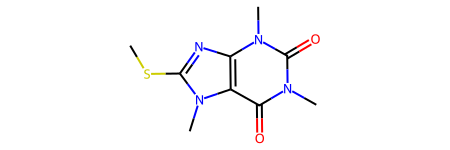

In [25]:
Chem.MolFromSmiles(SELFIES_CODER.SELFIES_to_SMILES(data[0]))

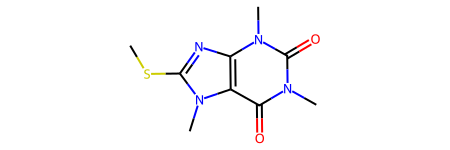

In [26]:
Chem.MolFromSmiles(list(smiles_train)[0])

## Proper translation of molecule

In [27]:
data_ = SELFIES_CODER.make_array(data)

In [28]:
translation = SELFIES_CODER.translate_SELFIES_array_into_one_hot(data_, SELFIES_to_one_hot)

In [29]:
translation[0]

':+&A:&.+:%:6&1+&:::&.=:1.7:.+%'

In [30]:
decoded_SELFIES = []
for i in range(len(translation)):
    decoded_ = SELFIES_CODER.convert_back_to_SEFLIES(translation[i], One_hot_to_SELFIES)
    decoded_SELFIES.append(decoded_)
decoded_SELFIES[0]

'[C][N][Branch1][#Branch1][C][Branch1][Ring1][N][C][=O][C][=C][Branch1][=N][N][Branch1][C][C][C][Branch1][Ring1][S][C][=N][Ring1][Branch2][C][Ring1][N][=O]'

In [31]:
data = translation

In [32]:
shap = len(list(smiles_train))
shap

58

In [33]:
#vectorization of SMILES code
def vectorize(mol_seqs, shap):
        one_hot =  np.zeros((shap, embed , len(charset)),dtype=np.int8)
        for i,mol_seq in enumerate(mol_seqs):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(mol_seq):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(mol_seq)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
mol_seqs_pred_ = data

X_train = vectorize(mol_seqs_pred_, shap)

print(smiles_train.iloc[0])

CN(C(N1C)=O)C2=C(N(C)C(SC)=N2)C1=O


In [34]:
mol_seqs_pred_[0:5]

[':+&A:&.+:%:6&1+&:::&.=:1.7:.+%',
 ":+:7.=+&::::+7.&:6&+'6&A:&.*:%8#&:5%:1:6B.A:&1+&:::&&+.A:%%",
 ':+7.1:7.7:&=+&:::&7+::+::+16.:+:%:.B%',
 ":+:7.>+&:::::+7.&:6&+'6&A:&.*:%8#&:5%:1:6B.7:&1+&:::&&+.A:%%",
 ':+:&>=:1:6&B+.&:6:6.A1:6.):@:%+&:::@:%+.$:']

In [35]:
#going back from vectorized form to redable string
string_test = "".join([int_to_char[idx] for idx in np.argmax(X_train[0][1,:,:], axis=1)])
print(string_test)

decoded = SELFIES_CODER.convert_back_to_SEFLIES(string_test, One_hot_to_SELFIES)
print(decoded)

decoded_two = SELFIES_CODER.convert_back_to_SEFLIES(mol_seqs_pred_[1], One_hot_to_SELFIES)
print(decoded_two)

print("Correct encoding-decoding: "+str(decoded == decoded_two))

!:+:7.=+&::::+7.&:6&+'6&A:&.*:%8#&:5%:1:6B.A:&1+&:::&&+.A:%%EEEEEEEEEEEEEEEEEEEEEEEEEEE
[C][N][C][Branch2][Ring1][S][N][Branch1][C][C][C][C][N][Branch2][Ring1][Branch1][C][=C][Branch1][N][/C][=C][Branch1][#Branch1][C][Branch1][Ring1][O][C][=O][\S][N+1][Branch1][C][O-1][=O][C][=N][C][=C][Ring2][Ring1][#Branch1][C][Branch1][=N][N][Branch1][C][C][C][Branch1][Branch1][N][Ring1][#Branch1][C][=O][=O]
[C][N][C][Branch2][Ring1][S][N][Branch1][C][C][C][C][N][Branch2][Ring1][Branch1][C][=C][Branch1][N][/C][=C][Branch1][#Branch1][C][Branch1][Ring1][O][C][=O][\S][N+1][Branch1][C][O-1][=O][C][=N][C][=C][Ring2][Ring1][#Branch1][C][Branch1][=N][N][Branch1][C][C][C][Branch1][Branch1][N][Ring1][#Branch1][C][=O][=O]
Correct encoding-decoding: True


In [36]:
mol_seqs_pred_[1]

":+:7.=+&::::+7.&:6&+'6&A:&.*:%8#&:5%:1:6B.A:&1+&:::&&+.A:%%"

In [37]:
new_smi_approach = vectorize(mol_seqs_pred_, shap)

In [38]:
new_smi_approach[0:1]

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [39]:
len(new_smi_approach[0])

58

In [40]:
new_smi_approach[0].shape #INPUT

(58, 87, 34)

In [41]:
new_smi_approach[1].shape #OUTPUT

(58, 87, 34)

In [42]:
x_latent_new = mol_seq_to_latent_model.predict(new_smi_approach[0:1])

In [43]:
x_latent_new.shape

(58, 128)

In [44]:
x_latent_new[2]

array([ 0.        ,  8.994374  , 16.412947  ,  0.        ,  4.861601  ,
        0.        ,  0.        , 18.192896  ,  0.        ,  1.0788895 ,
        0.        ,  2.3082554 ,  0.        ,  0.        ,  3.428016  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       20.166084  ,  0.        ,  0.        ,  1.9816866 ,  0.        ,
        0.        ,  0.        ,  0.        ,  7.0261917 ,  0.        ,
        0.        ,  0.77952313,  0.        ,  0.        ,  0.        ,
        0.        ,  3.307103  ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 26.317297  ,  7.098881  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 10.137559  ,  2.312395  ,  0.        ,  0.  

In [45]:
x_latent_new[3]

array([ 0.       ,  0.       ,  8.706826 ,  0.       , 10.098713 ,
        0.       ,  0.       , 21.929062 ,  0.       ,  4.556752 ,
        0.       ,  1.472856 ,  0.       ,  0.       ,  5.355751 ,
        0.       ,  0.       ,  0.       ,  5.5199175,  0.       ,
       18.48488  ,  1.7808976,  0.       , 15.682341 ,  0.       ,
        0.       ,  0.       ,  0.       , 13.204873 ,  0.       ,
        0.       ,  4.1941285,  0.       ,  0.       ,  0.       ,
        0.       ,  6.3551016,  0.       ,  0.       ,  0.       ,
        0.       ,  2.4788482,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       , 22.617485 , 13.80306  ,
        0.       ,  0.       ,  7.6421266,  0.       ,  0.       ,
        0.       ,  5.031401 ,  0.       , 10.636105 ,  0.       ,
        0.       , 30.008572 , 13.608    ,  0.       ,  0.       ,
        0.       ,  5.9611835,  0.       ,  0.       ,  4.6394

In [46]:
x_latent_new[2:3]

array([[ 0.        ,  8.994374  , 16.412947  ,  0.        ,  4.861601  ,
         0.        ,  0.        , 18.192896  ,  0.        ,  1.0788895 ,
         0.        ,  2.3082554 ,  0.        ,  0.        ,  3.428016  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        20.166084  ,  0.        ,  0.        ,  1.9816866 ,  0.        ,
         0.        ,  0.        ,  0.        ,  7.0261917 ,  0.        ,
         0.        ,  0.77952313,  0.        ,  0.        ,  0.        ,
         0.        ,  3.307103  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 26.317297  ,  7.098881  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 10.137559  ,  2.312395  ,  0. 

In [47]:
def latent_to_mol_seq(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,len(charset))) #last value should be eddited
    samplevec[0,0,startidx] = 1
    mol_seq = ""
    #Loop and predict next char
    for i in range(embed): #range is the smiles length - should be properly fixed
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            mol_seq = mol_seq + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,len(charset))) #last value should be eddited
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return mol_seq

In [48]:
molecular_sequence = latent_to_mol_seq(x_latent_new[0:1])

In [49]:
molecular_sequence

':+&$::::::+:1:6B.::&1+&:::&&+.A:%'

In [50]:
decoded = SELFIES_CODER.convert_back_to_SEFLIES(molecular_sequence, One_hot_to_SELFIES)
print(decoded)

[C][N][Branch1][=Branch2][C][C][C][C][C][C][N][C][=N][C][=C][Ring2][Ring1][C][C][Branch1][=N][N][Branch1][C][C][C][Branch1][Branch1][N][Ring1][#Branch1][C][=O]


In [51]:
def SELFIES_to_SMILES(SELFIES):
    
    smi = sf.decoder(SELFIES)
    
    return smi

In [52]:
new_SMILES = SELFIES_to_SMILES(decoded)
print(new_SMILES)

C1N(CCCCCCNC)NC2=C1CN(C)C(N2C)=O


In [53]:
#Sample around the latent wector
scale = 0.20
mols = []

for i in range(x_latent_new.shape[0]):
    for elem in range(20):
        latent_r = x_latent_new[i:i+1] + scale*(np.random.randn(x_latent_new[i:i+1].shape[1]))
        mol_seq = latent_to_mol_seq(latent_r)
        decoded = SELFIES_CODER.convert_back_to_SEFLIES(mol_seq, One_hot_to_SELFIES)
        new_SMI = SELFIES_to_SMILES(decoded)
        mol = Chem.MolFromSmiles(new_SMI)
        if mol:
            mols.append(new_SMI)
        
            print(i+1, "run ",elem+1, 'try, ', 'Correct molecule...', ' ', new_SMI)
        else:
            print(i+1, "run ",elem+1, 'try,', "ERROR", ' ', new_SMI)

1 run  1 try,  Correct molecule...   CN(C=1SC2=CC=CC=C2)N=1
1 run  2 try,  Correct molecule...   CN(C=1SC2=CC=CC=C2)N=1
1 run  3 try,  Correct molecule...   CN(CCCCCCNC1)NC2=C(C(N(C)C(N2C)=O)=O)N1
1 run  4 try,  Correct molecule...   CN(CCCC1CCNC)NC2=C(C(N(C)C(N2C)=O)=O)N1
1 run  5 try,  Correct molecule...   CN(CCC=1CCNC=N)C2=C(C(N(C)C(=O)N2C)=O)N=1
1 run  6 try,  Correct molecule...   C1N(CCCCCCNC)NC2=C1CN(C)C(N2C)=O
1 run  7 try,  Correct molecule...   C1N(CCC2CNCNC)C=C2N(C)C(N1C)=O
1 run  8 try,  Correct molecule...   C1N(CCCCCCNC)N2C=C1N(C)C(=O)N(C)C2=O
1 run  9 try,  Correct molecule...   C1N(CCCCCCNC)NC2=C1CN(C)C(N2C)=O
1 run  10 try,  Correct molecule...   C1N(CCCCCCNC)NC=C1CN(C)C(NC)=O
1 run  11 try,  Correct molecule...   C=12N=C(NCCN)N(C=1CN(C2=O)C)OC
1 run  12 try,  Correct molecule...   C1N(CCCCCCNC)NC2=C1CN(C)C(N2C)=O
1 run  13 try,  Correct molecule...   C1N(CCCCCCNC)NC2=C1CN(C)C(N2C)=O
1 run  14 try,  Correct molecule...   CN(CCCCCN1C=N)C2=C(C(N(C)C(N2C)=O)C)ON1
1 run  

5 run  10 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  11 try,  Correct molecule...   CNC=1N(C)C(=NC=1N(C(N(C)C=O)=O)C)NCCCNCCCN
5 run  12 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  13 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  14 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  15 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  16 try,  Correct molecule...   CN1C=2N(C)C(=NC=2C(N(C1=O)C)=O)NCCCN3C(CCC3=O)=O
5 run  17 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  18 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
5 run  19 try,  Correct molecule...   CN1C(=NC2=C1C(N(C)C(=O)N2C)=O)NCCCNCCCCNCCN
5 run  20 try,  Correct molecule...   CN1C(SC2=NC3=C(S2)C=CC=C3)=NC4=C1C(=O)N(C)C(=O)N4C
6 run  1 try,  Correct molecule...   O

10 run  7 try,  Correct molecule...   C=12N(CN2C(=O)C=1N(C)C(N(C)CCCCCNCC)=N)C=O
10 run  8 try,  Correct molecule...   C1NC(N(C)C(C=2N(C(NCCCCCN)=NC=2N1)C)=O)C=O
10 run  9 try,  Correct molecule...   C=12N(CN2C(=O)C=1N(C)C(SC(N3CCCC3)=S)=N)CC
10 run  10 try,  Correct molecule...   C=12NC(N(C)C(C=1NC(=N2)NCCCNCCCNC=O)C)=O
10 run  11 try,  Correct molecule...   C=12N(CN(C)C(C=1NC(=N2)NCC/N=C/SCC=O)N)C=O
10 run  12 try,  Correct molecule...   C=1N(C(N(C)CC=1NC(=N)NCCCNCCCNC=O)=O)C
10 run  13 try,  Correct molecule...   C=12N(CN(C)C(C=1NC(=N2)NCC/N=C/SCC=O)N)C=O
10 run  14 try,  Correct molecule...   C=12NC(N(C)C(C=1NC(=N2)N(CCN(C)C)C)C)=O
10 run  15 try,  Correct molecule...   C=12N(CN2C(=O)C=1N(C)C(SC(N3CCCC3)=S)=N)C=O
10 run  16 try,  Correct molecule...   C=12NC(N(C)C(C=1NC(=N2)NCCCNCCCNC=O)C)=O
10 run  17 try,  Correct molecule...   C=12N(CN2C(=O)C=1N(C)C(SC(N3CCCC3)=S)=N)C=O
10 run  18 try,  Correct molecule...   C=12N(CN2C(=O)C=1N(C)C(SC(N3CCCC3)=S)=N)C=O
10 run  19 try,  Correct mo

14 run  16 try,  Correct molecule...   O=C1C2=C(N=C(NCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
14 run  17 try,  Correct molecule...   O=C1C2=C(N=C(NCCCN3C(C=CC3=O)=O)N2)CN(C)C(N1C)=O
14 run  18 try,  Correct molecule...   O=C1C2=C(N=C(NCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
14 run  19 try,  Correct molecule...   O=C1C2=C(N=C(NCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
14 run  20 try,  Correct molecule...   O=C1C2=C(N=C(NCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
15 run  1 try,  Correct molecule...   C1=2N(CC1C=2CN(C)C(=O)NC)ONCCCNCCCNC
15 run  2 try,  Correct molecule...   C1N(CC1N(C)C)CN(C)CC=2N=NN(C=2)C(=O)N(C(NC)=O)C
15 run  3 try,  Correct molecule...   C1N(CC1CC=2)N(C)C=3N(C)C(=O)N(C)C(C=3N=2)=O
15 run  4 try,  Correct molecule...   CN(CCCCCC=1CCN)CC=NC=2C(=O)N(C)C(=O)N(C)C=2N=1
15 run  5 try,  Correct molecule...   C1N(CC1CC)CNC=2N(C)C3=C(N(C)C(=O)N(C)C3=O)N=2
15 run  6 try,  Correct molecule...   C1N(CC1CC)CNC=2N(C)C3=C(N(C)C(=O)N(C)C3=O)N=2
15 run  7 try,  Correct molecule...   C123N(CC1C=C2C)C=4N=NN(CCC

20 run  3 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(N(C)C(=O)N(C)C2=O)N=1
20 run  4 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(N(C)C(=O)N(C)C2=O)N=1
20 run  5 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(C(=O)N(C)C(=O)N2C)N=1
20 run  6 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(N(C)C(N(C2=O)C)=O)N=1
20 run  7 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(N(C)C(=O)N(C)C2=O)N=1
20 run  8 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)CN(C)C(=O)C=2N
20 run  9 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)CN(C)C(=O)C=2N
20 run  10 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(N(C)C(N(C)C2=O)=O)N=1
20 run  11 try,  Correct molecule...   C1N(CC2=CC=CC=C2)C=NCN(C)CN(C)C(=O)C1
20 run  12 try,  Correct molecule...   CN(C=1CCCCCNC)NC2=C(C(=O)N(C)C(=O)N2C)N=1
20 run  13 try,  Correct molecule...   CN(C=1C2=CC=CC=C2)C=NC=3N(C)CN(C)C(=O)C=3N=1
20 run  14 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)CN(C)C(=O)C=2N
20 run  15 try,  Correct molecule...   

25 run  1 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCC=5CCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1=5
25 run  2 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCC=5CCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1=5
25 run  3 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCC=5CCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1=5
25 run  4 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCC=5CCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1=5
25 run  5 try,  Correct molecule...   O=CC=C(N=CSC1=NC2=CC=CC=C2N1CC3=CN(CCCCCCCCN=[N+1]=[N-1])N=N3)CCC(=O)NC=O
25 run  6 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCC=5CCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1=5
25 run  7 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCC=5CCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1=5
25 run  8 try,  Correct molecule...   O=CC1=C(N=CSC2=NC3=CC=CC=C3N2CC4=CN(CCCCCCCCN=[N+1]=[N-1])N=N4)CCC(=O)N(C)C1
25 run  9 try,  Correct molecule...   O=CC=CCN1C2=CC=CC=C2N

29 run  15 try,  Correct molecule...   CN1C(NCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N3C)=O)=O
29 run  16 try,  Correct molecule...   CN1C(NCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N3C)=O)=O
29 run  17 try,  Correct molecule...   CN1C(NCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N3C)=O)=O
29 run  18 try,  Correct molecule...   CN1C(NCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N3C)=O)=O
29 run  19 try,  Correct molecule...   CN1C(NCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N3C)=O)=O
29 run  20 try,  Correct molecule...   CN1C(NCCNC(CSC(N2CCCC2)=S)=O)=NC3=C1C(N(C)C(N3C)=O)=O
30 run  1 try,  Correct molecule...   CN1C(NCC/N=C2\NC(CS2)=O)=NC3=C1C(N(C)C(N3C)=O)=O
30 run  2 try,  Correct molecule...   CN1C(SC(N2CCCC2)=S)=NC3=C1C(N(C)C(N3C)=O)=O
30 run  3 try,  Correct molecule...   CN1C(NCC/N=C2\NC(CS2)=O)=NC3=C1C(N(C)C(N3C)=O)=O
30 run  4 try,  Correct molecule...   CN1C(NCC/N=C2\NC(=O)CS2)=NC3=C1C(N(C)C(N3C)=O)=O
30 run  5 try,  Correct molecule...   CN1C(SC(N2CCCC2)=S)=NC3=C1C(N(C)C(=O)N3C)=O
30 run  6 try,  C

34 run  5 try,  Correct molecule...   C1N(C=2C=CCCNCCC3=CC=CC=C3CNC)C=21
34 run  6 try,  Correct molecule...   C=1N(CC=CC=O)N(C)C2=C(N(C(=O)N(C)C2=O)C)N=1
34 run  7 try,  Correct molecule...   CN(CC=CC1=O)N(C)C2=C(N(C)C(=O)N(C)C2=O)N1
34 run  8 try,  Correct molecule...   CN(CC1=C2C=CC=C1)CCN(C)C3=C(N(C(=O)N(C)C3=O)C)N2
34 run  9 try,  Correct molecule...   CN(CC=CC1=O)N(C)C2=C(N(C)C(=O)N(C)C2=O)N1
34 run  10 try,  Correct molecule...   C=1N(CC=CC=O)NC2=C(N(C(=O)N(C)C2=O)C)N=1
34 run  11 try,  Correct molecule...   C#1N(CC=CC#1)NC(N(C)C=O)CN(C)CC
34 run  12 try,  Correct molecule...   CN(CC=CC=O)N(C)C1=C(N(C)C(=O)N(C)C1=O)N
34 run  13 try,  Correct molecule...   CN(CC1=C2C=CC=C1)CCN(C)C3=C(N(C(=O)N(C)C3=O)C)N2
34 run  14 try,  Correct molecule...   CN(CC1=C2C=CC=C1)CCN(C)C3=C(N(C(=O)N(C)C3=O)C)N2
34 run  15 try,  Correct molecule...   C=1N(CC=CC=O)CCC2=C(N(C)C(=O)N(C)C2=O)N=1
34 run  16 try,  Correct molecule...   C=1N(CC=CC=O)NC2=C(N(C)C(N(C)C2=O)=O)N=1
34 run  17 try,  Correct molecu

39 run  5 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  6 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  7 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  8 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  9 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  10 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  11 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  12 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  13 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  14 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(C=CC3=O)=O)N2C)N(C)C(N1C)=O
39 run  15 try,  Correct molecule...   O=C1C2=C(N=C(NCCCCN3C(CCC3=O)=O)N2C)N(C)C(N1C)=O
39 run  16 try,  Correct mo

43 run  14 try,  Correct molecule...   CN(CC1=CC=O)N(C)C=2C(=O)N(C)C(=O)N(C)C=2N1
43 run  15 try,  Correct molecule...   CN(CC1=CC=O)N(C)C=2C(=O)N(C)C(=O)N(C)C=2N1
43 run  16 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)C(=O)N(C)C(=O)C=2N
43 run  17 try,  Correct molecule...   CN(CC1=CC=O)N(C)C=2C(=O)N(C)C(=O)N(C)C=2N1
43 run  18 try,  Correct molecule...   C1N(CC2=CC1=O)CCC=3C(=O)N(C)C(=O)N(C)C=3N2
43 run  19 try,  Correct molecule...   CN(CC=CCCNCC=1N=NN(C=1)CCCCC)N=[N+1]=[N-1]
43 run  20 try,  Correct molecule...   CN(CC1=CC=CC=C1)CC=2N=NN(C=2)CCCCCCCCN=[N+1]=[N-1]
44 run  1 try,  Correct molecule...   C=12NCN(C(=O)C=1N(C(=N2)NCCCNCCCNC)C)O
44 run  2 try,  Correct molecule...   CN(C(N(C(=O)C=1N(C(=NC=1)NCCCNCC)C)N)C)C
44 run  3 try,  Correct molecule...   C=12NCN(C(=O)C=1N(C(=N2)NCCCNCCCNC)C)O
44 run  4 try,  Correct molecule...   CN(C(NC(=O)C=1N(C)C(=NC=1)NCCNC)C)C=O
44 run  5 try,  Correct molecule...   C=12NCN(C(=O)C=1N(C(=N2)NCCCNCCCNC)C)O
44 run  6 try,  Correct molecu

48 run  9 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)CN(C)C(=O)C=2
48 run  10 try,  Correct molecule...   CN(C=1C2=CC=CC=C2)C=NC=3N(C)CN(C)C(=O)C=3N=1
48 run  11 try,  Correct molecule...   CN(C=1C2=CC=CC=C2)C=NC=3N(C)CN(C)C(=O)C=3N=1
48 run  12 try,  Correct molecule...   C1N(CC2=CC=CC=C2)C=NC=3N(C)C(=O)NC(=O)C1=3
48 run  13 try,  Correct molecule...   C12N(CC=CC1)C3=C(C(=O)N(C)C(=O)N3C)C=C2
48 run  14 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)CN(C)C(=O)C=2
48 run  15 try,  Correct molecule...   CN(CCN(C)C=C1C=C(NNC)CCOO)C1=O
48 run  16 try,  Correct molecule...   CN(C1C2=CC=CC=C2)C=NC=3N(C)C(=O)N(C)C(=O)C=31
48 run  17 try,  Correct molecule...   C#1N(CC=CC#1)C=SN(C)C(NC)=O
48 run  18 try,  Correct molecule...   CN(C1C2=CC=CC=C2)C=NC=3N(C)C(=O)N(C)C(=O)C=31
48 run  19 try,  Correct molecule...   CN(CC1=CC=CC=C1)C=NC=2N(C)CN(C)C(=O)C=2N
48 run  20 try,  Correct molecule...   CN(C1C2=CC=CC=C2)C=NC=3N(C)C(=O)N(C)C(=O)C=31
49 run  1 try,  Correct molecule...   O=C1

52 run  6 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(CN=[N+1]=[N-1])C=C6)N=N5)N2C)N(C)C(N1C)=O
52 run  7 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(C=C6)CN=[N+1]=[N-1])N=N5)N2C)N(C)C(N1C)=O
52 run  8 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(CN=[N+1]=[N-1])C=C6)N=N5)N2C)N(C)C(N1C)=O
52 run  9 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(C=C6)CN=[N+1]=[N-1])N=N5)N2C)N(C)C(N1C)=O
52 run  10 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(CN=[N+1]=[N-1])C=C6)N=N5)N2C)N(C)C(N1C)=O
52 run  11 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(C=C6)CN=[N+1]=[N-1])N=N5)N2C)N(C)C(N1C)=O
52 run  12 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(CN=[N+1]=[N-1])C=C6)N=N5)N2C)N(C)C(N1C)=O
52 run  13 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=CC=C(C=C6)C

56 run  18 try,  Correct molecule...   C=12N(CN(C(=O)C=1NC(=N2)NCCCCCC)NC)C=O
56 run  19 try,  Correct molecule...   C=12N(C(N(C(=O)C=1NC(=N2)NCCCCCC)N)C)C=O
56 run  20 try,  Correct molecule...   C=12N(C(N(C(=O)C=1NC(=N2)NCCCCCC)N)C)C=O
57 run  1 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=C(CN=[N+1]=[N-1])C=CC=C6)N=N5)N2C)N(C)C(N1C)=O
57 run  2 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=C(CN=[N+1]=[N-1])C=CC=C6)N=N5)N2C)N(C)C(N1C)=O
57 run  3 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=C(C=CC=C6)CN=[N+1]=[N-1])N=N5)N2C)N(C)C(N1C)=O
57 run  4 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=C(CN=[N+1]=[N-1])C=CC=C6)N=N5)N2C)N(C)C(N1C)=O
57 run  5 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=C(CN=[N+1]=[N-1])C=CC=C6)N=N5)N2C)N(C)C(N1C)=O
57 run  6 try,  Correct molecule...   O=C1C2=C(N=C(SC3=NC4=C(C=CC=C4)N3CC5=CN(CC6=C(CN=[N+1]=[N-1])C=CC=C6)N=N5)N2C)N

In [54]:
len(mols)

1160

In [55]:
def remove_duplicates_from_list(x_list):
    
      return list(dict.fromkeys(x_list))

In [56]:
mols = remove_duplicates_from_list(mols)

In [57]:
len(mols)

417

In [58]:
mols_ = []
for smi in mols:
    xcv = Chem.MolFromSmiles(smi)
    mols_.append(xcv)

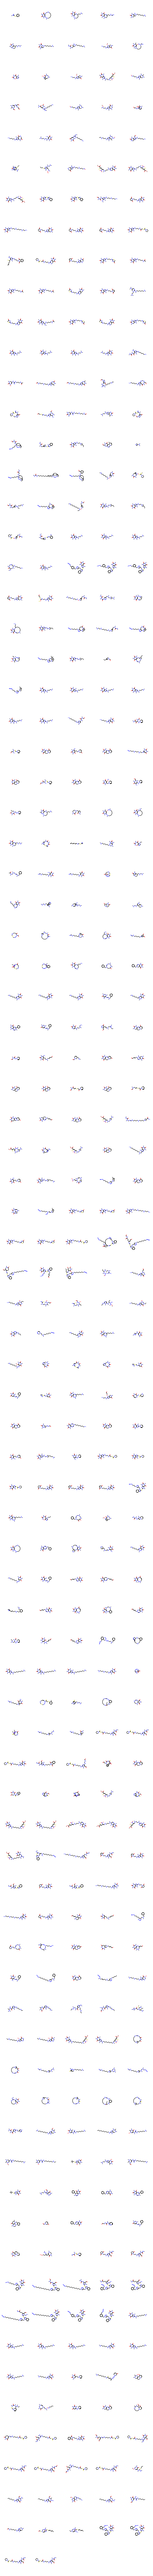

In [59]:
Draw.MolsToGridImage(mols_, molsPerRow=5, maxMols=int(len(mols)+5))

In [60]:
dataframe_created_molecules = pd.DataFrame(mols, columns=["SMILES_From_Tensor_rotation"])
dataframe_created_molecules.to_excel('../Data/Molecules_generated_tensor_scaling_0_2.xlsx')

# deciphered SMILES

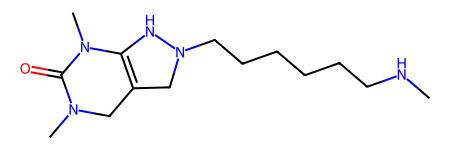

In [61]:
Chem.MolFromSmiles(SELFIES_to_SMILES(SELFIES_CODER.convert_back_to_SEFLIES(molecular_sequence, One_hot_to_SELFIES)))

# original SMILES

In [62]:
list(smiles_train)[0]

'CN(C(N1C)=O)C2=C(N(C)C(SC)=N2)C1=O'

In [63]:
smiles_trainn = {smiles:Chem.MolFromSmiles(list(smiles_train)[smiles]) for smiles in range(len(smiles_train))}
smiles_trainn = list(smiles_trainn.values())

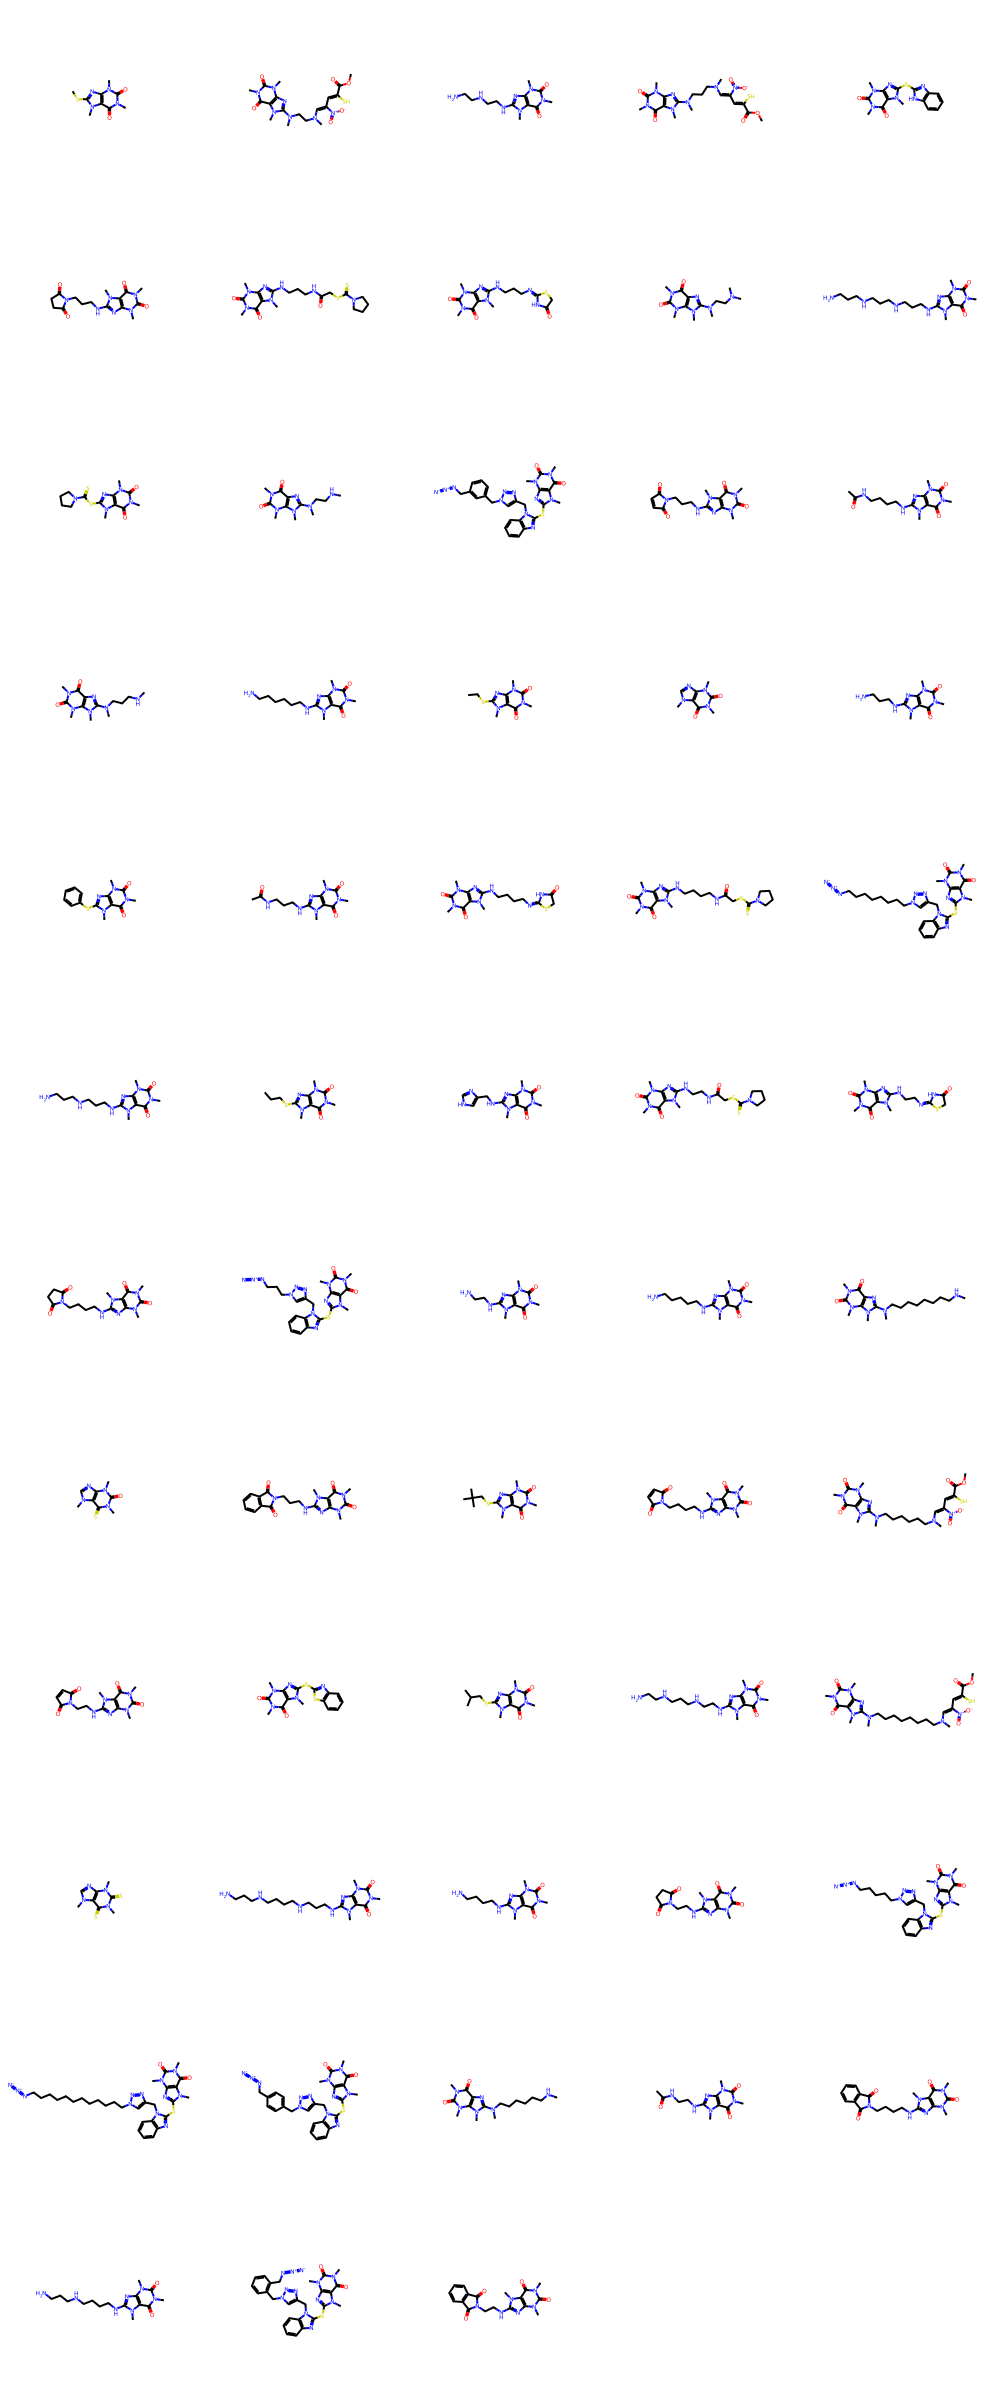

In [64]:
Draw.MolsToGridImage(smiles_trainn, molsPerRow=5, maxMols=int(len(smiles_trainn)+5))